<a href="https://colab.research.google.com/github/YunusovYF/neural_networks/blob/main/RNN_%D0%B8_CNN_%D0%B2_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B5_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_Ultra_Pro%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra pro

Выгрузите какой-нибудь из ваших диалогов любой соц.сети и напишите нейронную сеть для классификации собеседника по сообщению. 

Использование групповых чатов для обучения поощряется, но усложняет задачу. Если необходима конфиденциальность, датасет можно не предоставлять.

Если вы решали эту задачу и для предыдущего занятия, то дополнительно необходимо провести эксперименты по разным сетям, сравнить качество и написать вывод, какой подход показал большую точность: с BOW или с CNN\RNN.

In [ ]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time

import codecs 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.DataFrame(columns=['name', 'message'])

In [ ]:
# перебираем архив сообщений диалога из вк и составляем датафрейм
for root, dirs, files in os.walk('/content/drive/MyDrive/Baza/2000000101'):
  for file in files:
    fileBody = codecs.open('/content/drive/MyDrive/Baza/2000000101/'+str(file), 'r', 'windows-1251') 
    m=0
    n=0

    for line in fileBody:
      words = line.lstrip().split(sep='>')
      # print(words)
      for word in words:
        if m==1 and word=='<div':
          mess=words[1].split('>')
          mess=str(mess[0].split('<')[0])
          m=0
          n=1
        if word == '<div class="message__header"':
          m = 1
          if str(words[1])[:8]=='<a href=':
            name=str(words[2].split('<')[0])
            n=0
          else:
            name=str(words[1].split(',')[0])
            n=0
      if n==1:
        df = pd.DataFrame(np.array([[name,mess]]), columns=['name', 'message']).append(df, ignore_index=True)
        n=0

In [ ]:
i=1
for cl in df['name'].unique(): #Проходим по всем классам
  df.loc[df["name"]==cl, "name"] = 'Человек '+str(i)
  i+=1

In [ ]:
!rm -R /content/texts # Проверяем наличие папки texts. Если есть, удаляем ее

rm: cannot remove '/content/texts': No such file or directory


In [ ]:
print(df.shape) #Выведем форму таблицы

(6320, 2)


In [ ]:
print(df.values[1]) #Выведем пример из таблицы 

['Человек 2' 'Приеду через неделю&#128517;']


In [ ]:
for cl in df['name'].unique(): #Проходим по всем классам
  print('Количество записей класса ', cl, ': ', df[df.name == cl].shape[0])
  

Количество записей класса  Человек 1 :  662
Количество записей класса  Человек 2 :  117
Количество записей класса  Человек 3 :  1775
Количество записей класса  Человек 4 :  1324
Количество записей класса  Человек 5 :  16
Количество записей класса  Человек 6 :  1148
Количество записей класса  Человек 7 :  15
Количество записей класса  Человек 8 :  262
Количество записей класса  Человек 9 :  41
Количество записей класса  Человек 10 :  371
Количество записей класса  Человек 11 :  33
Количество записей класса  Человек 12 :  138
Количество записей класса  Человек 13 :  1
Количество записей класса  Человек 14 :  7
Количество записей класса  Человек 15 :  1
Количество записей класса  Человек 16 :  6
Количество записей класса  Человек 17 :  30
Количество записей класса  Человек 18 :  54
Количество записей класса  Человек 19 :  13
Количество записей класса  Человек 20 :  3
Количество записей класса  Человек 21 :  116
Количество записей класса  Человек 22 :  5
Количество записей класса  Человек 

In [ ]:
texts = df['message'].values #Извлекаем данные всех текстов из столбца text
classes = list(df['name'].values) #Извлекаем соответствующие им значения классов (лейблов) столбца text
maxWordsCount = 60000 #Зададим максимальное количество слов/индексов, учитываемое при обучении текстов

print(df['name'].unique()) #Выводим все уникальные значения классов
nClasses = df['name'].nunique()+1  #Задаём количество классов, обращаясь к столбцу category и оставляя уникальные значения
print(nClasses) #Посмотрим на количество классов

['Человек 1' 'Человек 2' 'Человек 3' 'Человек 4' 'Человек 5' 'Человек 6'
 'Человек 7' 'Человек 8' 'Человек 9' 'Человек 10' 'Человек 11'
 'Человек 12' 'Человек 13' 'Человек 14' 'Человек 15' 'Человек 16'
 'Человек 17' 'Человек 18' 'Человек 19' 'Человек 20' 'Человек 21'
 'Человек 22' 'Человек 23' 'Человек 24' 'Человек 25' 'Человек 26'
 'Человек 27' 'Человек 28' 'Человек 29' 'Человек 30' 'Человек 31'
 'Человек 32' 'Человек 33']
34


In [ ]:
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#Для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
#num_words=maxWordsCount - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
#lower=True - приводим слова к нижнему регистру
#split=' ' - разделяем слова по пробелу
#char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(texts) #"Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

#Формируем матрицу индексов по принципу Bag of Words
xAll = tokenizer.texts_to_matrix(texts) #Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой 
print(xAll.shape)  #Посмотрим на форму текстов
print(xAll[0, :20])#И отдельно на фрагмент начала вектора

(6320, 60000)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
print(tokenizer.word_index.items()) #Вытаскиваем индексы слов для просмотра

In [ ]:
print("Размер словаря", len(tokenizer.word_index.items()))

Размер словаря 7484


In [ ]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() # Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes) # Подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes) # Кодируем категории
print(encoder.classes_)
print(classesEncoded.shape)
print(classesEncoded[:10])

['Человек 1' 'Человек 10' 'Человек 11' 'Человек 12' 'Человек 13'
 'Человек 14' 'Человек 15' 'Человек 16' 'Человек 17' 'Человек 18'
 'Человек 19' 'Человек 2' 'Человек 20' 'Человек 21' 'Человек 22'
 'Человек 23' 'Человек 24' 'Человек 25' 'Человек 26' 'Человек 27'
 'Человек 28' 'Человек 29' 'Человек 3' 'Человек 30' 'Человек 31'
 'Человек 32' 'Человек 33' 'Человек 4' 'Человек 5' 'Человек 6' 'Человек 7'
 'Человек 8' 'Человек 9']
(6320,)
[ 0 11 22 11 27  0 27 27 22 27]


In [ ]:
yAll = utils.to_categorical(classesEncoded, nClasses) # И выводим каждый лейбл в виде вектора длиной 22, с 1кой в позиции соответствующего класса и нулями
print(yAll.shape) # Посмотрим на форму лейблов категорий
print(yAll[0]) # И отдельно на первую строку

(6320, 34)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2)
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

(5056, 60000)
(5056, 34)


Epoch 1/40
40/40 [==============================] - 3s 33ms/step - loss: 3.4314 - accuracy: 0.1669 - val_loss: 2.8726 - val_accuracy: 0.2896
Epoch 2/40
40/40 [==============================] - 1s 18ms/step - loss: 2.6564 - accuracy: 0.2827 - val_loss: 2.1749 - val_accuracy: 0.2896
Epoch 3/40
40/40 [==============================] - 1s 18ms/step - loss: 2.1663 - accuracy: 0.3096 - val_loss: 2.0538 - val_accuracy: 0.3275
Epoch 4/40
40/40 [==============================] - 1s 18ms/step - loss: 2.0380 - accuracy: 0.3343 - val_loss: 2.0048 - val_accuracy: 0.3394
Epoch 5/40
40/40 [==============================] - 1s 18ms/step - loss: 1.9617 - accuracy: 0.3641 - val_loss: 1.9721 - val_accuracy: 0.3639
Epoch 6/40
40/40 [==============================] - 1s 18ms/step - loss: 1.9221 - accuracy: 0.3867 - val_loss: 1.9447 - val_accuracy: 0.3703
Epoch 7/40
40/40 [==============================] - 1s 17ms/step - loss: 1.8786 - accuracy: 0.4105 - val_loss: 1.9240 - val_accuracy: 0.3734
Epoch 8/40
40

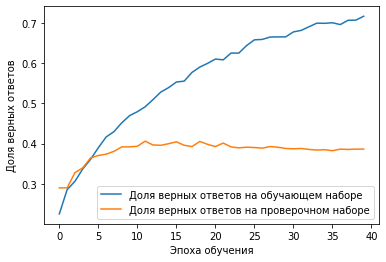

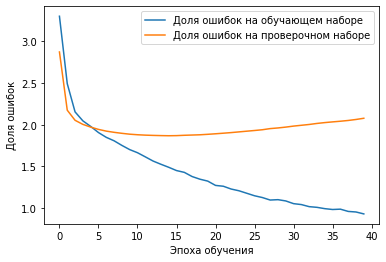

In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()
model01.add(Dense(300, input_dim=maxWordsCount, activation="relu"))
model01.add(Dropout(0.9))
model01.add(Dense(nClasses, activation='softmax'))


model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model01.fit(xTrain, 
                    yTrain, 
                    epochs=40,
                    batch_size=128,
                    validation_data=(xVal, yVal))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

plt.plot(history.history['loss'], 
         label='Доля ошибок на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Доля ошибок на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля ошибок')
plt.legend()
plt.show()

In [ ]:
def divideInHalf(str):
    return str[:round(4*len(str)/5)], str[round(4*len(str)/5):]

In [ ]:
trainText = []
testText = []
for el in df['name'].unique():
  newStr=''
  for index, row in df.loc[df['name'] == el].iterrows():
    newStr += row['message'] +' '
  a,b = divideInHalf(newStr)
  trainText.append(a)
  testText.append(b)

In [ ]:
maxWordsCount = 60000

tokenizer = Tokenizer(num_words=maxWordsCount, filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower=True, split=' ', char_level=False, oov_token = 'unknown')

tokenizer.fit_on_texts(trainText)
items = list(tokenizer.word_index.items())

In [ ]:
# Преобразуем текст в индекс согласно словарю

trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer. texts_to_sequences(testText)

In [ ]:
# Создание обучающей выборки

def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0

  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step

  return xSample

In [ ]:
# Создание обучающей и проверочной выборки

def createSetsMultiClasses(wordIndexes, xLen, step):

  nClasses = len(wordIndexes)
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))

  xSamples = []
  ySamples = []

  for t in range(nClasses):
    xT = classesXSamples[t]
    for i in range(len(xT)):
      xSamples.append(xT[i])

    curry = utils.to_categorical(t, nClasses)
    for i in range(len(xT)):
      ySamples.append(curry)

  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)
    
  return (xSamples, ySamples)

In [ ]:
# Задаём базовые параметры

xLen = 10
step = 5

In [ ]:
# Формируем выборки
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)

print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(4979, 10)
(4979, 33)
(1228, 10)
(1228, 33)


Epoch 1/60
39/39 [==============================] - 6s 17ms/step - loss: 2.7107 - accuracy: 0.2061 - val_loss: 1.9701 - val_accuracy: 0.3827
Epoch 2/60
39/39 [==============================] - 0s 11ms/step - loss: 2.1971 - accuracy: 0.3188 - val_loss: 1.9336 - val_accuracy: 0.3827
Epoch 3/60
39/39 [==============================] - 1s 14ms/step - loss: 2.1503 - accuracy: 0.3196 - val_loss: 1.9179 - val_accuracy: 0.3827
Epoch 4/60
39/39 [==============================] - 0s 11ms/step - loss: 2.1171 - accuracy: 0.3313 - val_loss: 1.9201 - val_accuracy: 0.3827
Epoch 5/60
39/39 [==============================] - 0s 11ms/step - loss: 2.0795 - accuracy: 0.3412 - val_loss: 1.9153 - val_accuracy: 0.3827
Epoch 6/60
39/39 [==============================] - 0s 11ms/step - loss: 2.0229 - accuracy: 0.3501 - val_loss: 1.9182 - val_accuracy: 0.3827
Epoch 7/60
39/39 [==============================] - 0s 11ms/step - loss: 1.9969 - accuracy: 0.3617 - val_loss: 1.9131 - val_accuracy: 0.3827
Epoch 8/60
39

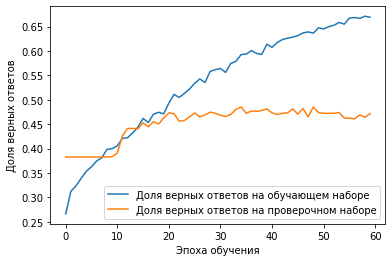

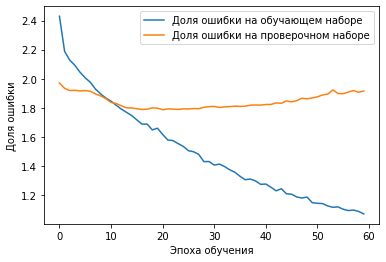

In [ ]:
# Создаём модель

modelEC = Sequential()

modelEC.add(Embedding(maxWordsCount, 50, input_length=xLen))

modelEC.add(SpatialDropout1D(0.9))
modelEC.add(BatchNormalization())

modelEC.add(Conv1D(30, 10, activation='sigmoid', padding='same'))
modelEC.add(MaxPooling1D(2))
modelEC.add(Dropout(0.5))
modelEC.add(Flatten())

modelEC.add(Dense(33, activation='softmax'))

# компилируем
modelEC.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# обучаем
history = modelEC.fit(xTrain,
                      yTrain,
                      epochs=60,
                      batch_size=128,
                      validation_data=(xTest, yTest))
# графики
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

plt.plot(history.history['loss'], 
         label='Доля ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Доля ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля ошибки')
plt.legend()
plt.show()

Выводы:
* добавление одномерной свёрточной сети привело не только к улучшению результата обучения, но и увеличение скорости обучения